# Spotify 1 Million Tracks - Tratamento e Modelação

### Importe das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score, confusion_matrix,f1_score, classification_report
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
%matplotlib inline


# Para visualizar os valores com cinco casas decimais
# pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Tratamento dos Dados

Carregar o dataset, previamente analisado

In [2]:
data = pd.read_csv('data.csv')
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


Eliminar coluns irrelevantes:
id e name

In [3]:
# Drop Id and Track Id columns
data.drop(['id', 'name', 'artists', 'release_date'], axis=1, inplace=True, errors='ignore')
data

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,0.9950,0.708,158648,0.1950,0,0.563000,10,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928
1,0.9940,0.379,282133,0.0135,0,0.901000,8,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928
2,0.6040,0.749,104300,0.2200,0,0.000000,5,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928
3,0.9950,0.781,180760,0.1300,0,0.887000,1,0.1110,-14.734,0,0,0.0926,108.003,0.7200,1928
4,0.9900,0.210,687733,0.2040,0,0.908000,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,163800,0.4430,1,0.000032,1,0.0891,-7.461,1,75,0.1430,100.012,0.3060,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


Remover duplicados

In [68]:
data.drop_duplicates(inplace=True)
data

0


/tmp/ipykernel_203206/1546586411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
4,0.9900,0.210,687733,0.2040,0,0.908000,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
11,0.9890,0.170,85133,0.0823,0,0.911000,10,0.0962,-30.107,0,1,0.0317,85.989,0.3460,1928
40,0.9770,0.305,215267,0.0830,0,0.697000,6,0.2310,-20.895,1,1,0.0331,80.622,0.0479,1928
42,0.9900,0.337,333907,0.0699,0,0.903000,5,0.1060,-23.806,0,2,0.0322,72.133,0.1350,1928
47,0.9850,0.355,138013,0.0452,0,0.825000,1,0.1530,-24.125,1,2,0.0329,84.551,0.2760,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,163800,0.4430,1,0.000032,1,0.0891,-7.461,1,75,0.1430,100.012,0.3060,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


Remover os registos com popularidade igual a 0 para termos uma melhor distribuição

In [5]:
data = data[data['popularity'] > 0]

Remover outliers por género

In [6]:
"""q3 = data.groupby(by=['genre']).quantile(0.75,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']
q1 = data.groupby(by=['genre']).quantile(0.25,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']

data_aux = data.merge(q1, left_on='genre', right_index=True, suffixes=('', '_q1'))
data_aux = data_aux.merge(q3, left_on='genre', right_index=True, suffixes=('', '_q3'))
data_aux['iqr'] = data_aux['popularity_q3'] - data_aux['popularity_q1']

#data_aux
# Verificar os outliers
no_outliers = data_aux[(data_aux['popularity'] <= data_aux['popularity_q3'] + 1.5 * data_aux['iqr']) & (data_aux['popularity'] >= data_aux['popularity_q1'] - 1.5 * data_aux['iqr'])]
no_outliers.drop(['popularity_q1', 'popularity_q3', 'iqr'], axis=1, inplace=True)
no_outliers"""

"q3 = data.groupby(by=['genre']).quantile(0.75,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']\nq1 = data.groupby(by=['genre']).quantile(0.25,numeric_only=True).sort_values(by='popularity', ascending=False)['popularity']\n\ndata_aux = data.merge(q1, left_on='genre', right_index=True, suffixes=('', '_q1'))\ndata_aux = data_aux.merge(q3, left_on='genre', right_index=True, suffixes=('', '_q3'))\ndata_aux['iqr'] = data_aux['popularity_q3'] - data_aux['popularity_q1']\n\n#data_aux\n# Verificar os outliers\nno_outliers = data_aux[(data_aux['popularity'] <= data_aux['popularity_q3'] + 1.5 * data_aux['iqr']) & (data_aux['popularity'] >= data_aux['popularity_q1'] - 1.5 * data_aux['iqr'])]\nno_outliers.drop(['popularity_q1', 'popularity_q3', 'iqr'], axis=1, inplace=True)\nno_outliers"

Converter valores categóricos para valores contínuos

In [7]:
"""data_non_categorical = data.copy()
lb_make = LabelEncoder()
data_non_categorical['artist_name'] = lb_make.fit_transform(data_non_categorical['artist_name'])
data_non_categorical['genre'] = lb_make.fit_transform(data_non_categorical['genre'])
data_non_categorical"""

"data_non_categorical = data.copy()\nlb_make = LabelEncoder()\ndata_non_categorical['artist_name'] = lb_make.fit_transform(data_non_categorical['artist_name'])\ndata_non_categorical['genre'] = lb_make.fit_transform(data_non_categorical['genre'])\ndata_non_categorical"

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142497 entries, 4 to 169908
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      142497 non-null  float64
 1   danceability      142497 non-null  float64
 2   duration_ms       142497 non-null  int64  
 3   energy            142497 non-null  float64
 4   explicit          142497 non-null  int64  
 5   instrumentalness  142497 non-null  float64
 6   key               142497 non-null  int64  
 7   liveness          142497 non-null  float64
 8   loudness          142497 non-null  float64
 9   mode              142497 non-null  int64  
 10  popularity        142497 non-null  int64  
 11  speechiness       142497 non-null  float64
 12  tempo             142497 non-null  float64
 13  valence           142497 non-null  float64
 14  year              142497 non-null  int64  
dtypes: float64(9), int64(6)
memory usage: 17.4 MB


### Remoção de outliers

Acousticness

In [9]:
q1 = data['acousticness'].quantile(0.25)
q3 = data['acousticness'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(data[data['acousticness'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(data[data['acousticness'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_acousticness = data[(data['acousticness'] <= q3 + 1.5 * (q3 - q1)) & (data['acousticness'] >= q1 - 1.5 * (q3 - q1))]

-1.0015
0
1.8377
0


Danceability

In [10]:
q1 = no_outliers_acousticness['danceability'].quantile(0.25)
q3 = no_outliers_acousticness['danceability'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_acousticness[no_outliers_acousticness['danceability'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_acousticness[no_outliers_acousticness['danceability'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_danceability = no_outliers_acousticness[(no_outliers_acousticness['danceability'] <= q3 + 1.5 * (q3 - q1)) & (no_outliers_acousticness['danceability'] >= q1 - 1.5 * (q3 - q1))]

0.06699999999999989
226
1.0350000000000001
0


Loudness

In [11]:
no_outliers_danceability.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142271 entries, 4 to 169908
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      142271 non-null  float64
 1   danceability      142271 non-null  float64
 2   duration_ms       142271 non-null  int64  
 3   energy            142271 non-null  float64
 4   explicit          142271 non-null  int64  
 5   instrumentalness  142271 non-null  float64
 6   key               142271 non-null  int64  
 7   liveness          142271 non-null  float64
 8   loudness          142271 non-null  float64
 9   mode              142271 non-null  int64  
 10  popularity        142271 non-null  int64  
 11  speechiness       142271 non-null  float64
 12  tempo             142271 non-null  float64
 13  valence           142271 non-null  float64
 14  year              142271 non-null  int64  
dtypes: float64(9), int64(6)
memory usage: 17.4 MB


In [12]:
q1 = no_outliers_danceability['loudness'].quantile(0.25)
q3 = no_outliers_danceability['loudness'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_danceability[no_outliers_danceability['loudness'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_danceability[no_outliers_danceability['loudness'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_loudness = no_outliers_danceability[(no_outliers_danceability['loudness'] <= q3 + 1.5 * (q3 - q1))]
no_outliers_loudness

-23.493
3647
3.4429999999999987
1


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
4,0.9900,0.210,687733,0.2040,0,0.908000,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
11,0.9890,0.170,85133,0.0823,0,0.911000,10,0.0962,-30.107,0,1,0.0317,85.989,0.3460,1928
40,0.9770,0.305,215267,0.0830,0,0.697000,6,0.2310,-20.895,1,1,0.0331,80.622,0.0479,1928
42,0.9900,0.337,333907,0.0699,0,0.903000,5,0.1060,-23.806,0,2,0.0322,72.133,0.1350,1928
47,0.9850,0.355,138013,0.0452,0,0.825000,1,0.1530,-24.125,1,2,0.0329,84.551,0.2760,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,163800,0.4430,1,0.000032,1,0.0891,-7.461,1,75,0.1430,100.012,0.3060,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


In [13]:
no_outliers_loudness.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142270 entries, 4 to 169908
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      142270 non-null  float64
 1   danceability      142270 non-null  float64
 2   duration_ms       142270 non-null  int64  
 3   energy            142270 non-null  float64
 4   explicit          142270 non-null  int64  
 5   instrumentalness  142270 non-null  float64
 6   key               142270 non-null  int64  
 7   liveness          142270 non-null  float64
 8   loudness          142270 non-null  float64
 9   mode              142270 non-null  int64  
 10  popularity        142270 non-null  int64  
 11  speechiness       142270 non-null  float64
 12  tempo             142270 non-null  float64
 13  valence           142270 non-null  float64
 14  year              142270 non-null  int64  
dtypes: float64(9), int64(6)
memory usage: 17.4 MB


Speechiness

In [14]:
q1 = no_outliers_loudness['speechiness'].quantile(0.25)
q3 = no_outliers_loudness['speechiness'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_loudness[no_outliers_loudness['speechiness'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_loudness[no_outliers_loudness['speechiness'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_speechiness = no_outliers_loudness[(no_outliers_loudness['speechiness'] <= q3 + 1.5 * (q3 - q1)) & (no_outliers_loudness['speechiness'] >= q1 - 1.5 * (q3 - q1))]
no_outliers_speechiness

-0.020149999999999987
0
0.12424999999999999
18645


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
4,0.9900,0.210,687733,0.2040,0,0.908000,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
11,0.9890,0.170,85133,0.0823,0,0.911000,10,0.0962,-30.107,0,1,0.0317,85.989,0.3460,1928
40,0.9770,0.305,215267,0.0830,0,0.697000,6,0.2310,-20.895,1,1,0.0331,80.622,0.0479,1928
42,0.9900,0.337,333907,0.0699,0,0.903000,5,0.1060,-23.806,0,2,0.0322,72.133,0.1350,1928
47,0.9850,0.355,138013,0.0452,0,0.825000,1,0.1530,-24.125,1,2,0.0329,84.551,0.2760,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169903,0.2100,0.795,218501,0.5850,0,0.000001,8,0.1120,-4.451,1,68,0.0374,97.479,0.9340,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


Valence

In [15]:
q1 = no_outliers_speechiness['valence'].quantile(0.25)
q3 = no_outliers_speechiness['valence'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_speechiness[no_outliers_speechiness['valence'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_speechiness[no_outliers_speechiness['valence'] >= q3 + 1.5 * (q3 - q1)].shape[0])


no_outliers_valence = no_outliers_speechiness[(no_outliers_speechiness['valence'] <= q3 + 1.5 * (q3 - q1)) & (no_outliers_speechiness['valence'] >= q1 - 1.5 * (q3 - q1))]
no_outliers_valence

-0.3389999999999998
0
1.4129999999999998
0


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
4,0.9900,0.210,687733,0.2040,0,0.908000,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
11,0.9890,0.170,85133,0.0823,0,0.911000,10,0.0962,-30.107,0,1,0.0317,85.989,0.3460,1928
40,0.9770,0.305,215267,0.0830,0,0.697000,6,0.2310,-20.895,1,1,0.0331,80.622,0.0479,1928
42,0.9900,0.337,333907,0.0699,0,0.903000,5,0.1060,-23.806,0,2,0.0322,72.133,0.1350,1928
47,0.9850,0.355,138013,0.0452,0,0.825000,1,0.1530,-24.125,1,2,0.0329,84.551,0.2760,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169903,0.2100,0.795,218501,0.5850,0,0.000001,8,0.1120,-4.451,1,68,0.0374,97.479,0.9340,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


Tempo

In [16]:
q1 = no_outliers_valence['tempo'].quantile(0.25)
q3 = no_outliers_valence['tempo'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_valence[no_outliers_valence['tempo'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_valence[no_outliers_valence['tempo'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_tempo = no_outliers_valence[(no_outliers_valence['tempo'] <= q3 + 1.5 * (q3 - q1)) & (no_outliers_valence['tempo'] >= q1 - 1.5 * (q3 - q1))]
no_outliers_tempo

35.78999999999999
11
196.318
1139


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
4,0.9900,0.210,687733,0.2040,0,0.908000,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
11,0.9890,0.170,85133,0.0823,0,0.911000,10,0.0962,-30.107,0,1,0.0317,85.989,0.3460,1928
40,0.9770,0.305,215267,0.0830,0,0.697000,6,0.2310,-20.895,1,1,0.0331,80.622,0.0479,1928
42,0.9900,0.337,333907,0.0699,0,0.903000,5,0.1060,-23.806,0,2,0.0322,72.133,0.1350,1928
47,0.9850,0.355,138013,0.0452,0,0.825000,1,0.1530,-24.125,1,2,0.0329,84.551,0.2760,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169903,0.2100,0.795,218501,0.5850,0,0.000001,8,0.1120,-4.451,1,68,0.0374,97.479,0.9340,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


Duration

In [17]:
q1 = no_outliers_tempo['duration_ms'].quantile(0.25)
q3 = no_outliers_tempo['duration_ms'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_tempo[no_outliers_tempo['duration_ms'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_tempo[no_outliers_tempo['duration_ms'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_duration = no_outliers_tempo[(no_outliers_tempo['duration_ms'] <= q3 + 1.5 * (q3 - q1)) & (no_outliers_tempo['duration_ms'] >= q1 - 1.5 * (q3 - q1))]
no_outliers_duration

35600.5
51
407972.5
5950


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
11,0.9890,0.170,85133,0.0823,0,0.911000,10,0.0962,-30.107,0,1,0.0317,85.989,0.3460,1928
40,0.9770,0.305,215267,0.0830,0,0.697000,6,0.2310,-20.895,1,1,0.0331,80.622,0.0479,1928
42,0.9900,0.337,333907,0.0699,0,0.903000,5,0.1060,-23.806,0,2,0.0322,72.133,0.1350,1928
47,0.9850,0.355,138013,0.0452,0,0.825000,1,0.1530,-24.125,1,2,0.0329,84.551,0.2760,1928
59,0.9910,0.839,162147,0.3700,0,0.041900,2,0.1040,-11.602,1,1,0.0800,115.063,0.9760,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169903,0.2100,0.795,218501,0.5850,0,0.000001,8,0.1120,-4.451,1,68,0.0374,97.479,0.9340,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


Energy

In [18]:
q1 = no_outliers_duration['energy'].quantile(0.25)
q3 = no_outliers_duration['energy'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_duration[no_outliers_duration['energy'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_duration[no_outliers_duration['energy'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_energy = no_outliers_duration[(no_outliers_duration['energy'] <= q3 + 1.5 * (q3 - q1)) & (no_outliers_duration['energy'] >= q1 - 1.5 * (q3 - q1))]
no_outliers_energy

-0.33
0
1.374
0


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
11,0.9890,0.170,85133,0.0823,0,0.911000,10,0.0962,-30.107,0,1,0.0317,85.989,0.3460,1928
40,0.9770,0.305,215267,0.0830,0,0.697000,6,0.2310,-20.895,1,1,0.0331,80.622,0.0479,1928
42,0.9900,0.337,333907,0.0699,0,0.903000,5,0.1060,-23.806,0,2,0.0322,72.133,0.1350,1928
47,0.9850,0.355,138013,0.0452,0,0.825000,1,0.1530,-24.125,1,2,0.0329,84.551,0.2760,1928
59,0.9910,0.839,162147,0.3700,0,0.041900,2,0.1040,-11.602,1,1,0.0800,115.063,0.9760,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169903,0.2100,0.795,218501,0.5850,0,0.000001,8,0.1120,-4.451,1,68,0.0374,97.479,0.9340,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


Instrumentalness

In [19]:
q1 = no_outliers_energy['instrumentalness'].quantile(0.25)
q3 = no_outliers_energy['instrumentalness'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_energy[no_outliers_energy['instrumentalness'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_energy[no_outliers_energy['instrumentalness'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_instrumentalness = no_outliers_energy[(no_outliers_energy['instrumentalness'] <= q3 + 1.5 * (q3 - q1)) & (no_outliers_energy['instrumentalness'] >= q1 - 1.5 * (q3 - q1))]
no_outliers_instrumentalness

-0.04035
0
0.06725
25054


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
59,0.9910,0.839,162147,0.3700,0,0.041900,2,0.104,-11.602,1,1,0.0800,115.063,0.976,1928
67,0.9470,0.333,122733,0.1460,0,0.000426,2,0.265,-16.990,1,2,0.0353,75.372,0.234,1928
82,0.9180,0.754,184840,0.1940,0,0.000043,3,0.188,-11.634,1,1,0.0530,84.042,0.454,1928
108,0.9510,0.690,169509,0.7140,0,0.000348,0,0.234,-15.857,0,2,0.0747,116.188,0.804,1930
117,0.8700,0.353,137090,0.0785,0,0.000002,0,0.112,-18.434,0,2,0.0376,70.535,0.261,1930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169903,0.2100,0.795,218501,0.5850,0,0.000001,8,0.112,-4.451,1,68,0.0374,97.479,0.934,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.111,-10.907,1,64,0.0403,128.000,0.270,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.108,-9.332,1,70,0.1050,123.700,0.153,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.222,-2.557,1,70,0.0385,129.916,0.472,2020


Liveness

In [20]:
q1 = no_outliers_instrumentalness['liveness'].quantile(0.25)
q3 = no_outliers_instrumentalness['liveness'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_instrumentalness[no_outliers_instrumentalness['liveness'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_instrumentalness[no_outliers_instrumentalness['liveness'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_liveness = no_outliers_instrumentalness[(no_outliers_instrumentalness['liveness'] <= q3 + 1.5 * (q3 - q1)) & (no_outliers_instrumentalness['liveness'] >= q1 - 1.5 * (q3 - q1))]
no_outliers_liveness

-0.1345
0
0.4759
5616


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
59,0.9910,0.839,162147,0.3700,0,0.041900,2,0.104,-11.602,1,1,0.0800,115.063,0.976,1928
67,0.9470,0.333,122733,0.1460,0,0.000426,2,0.265,-16.990,1,2,0.0353,75.372,0.234,1928
82,0.9180,0.754,184840,0.1940,0,0.000043,3,0.188,-11.634,1,1,0.0530,84.042,0.454,1928
108,0.9510,0.690,169509,0.7140,0,0.000348,0,0.234,-15.857,0,2,0.0747,116.188,0.804,1930
117,0.8700,0.353,137090,0.0785,0,0.000002,0,0.112,-18.434,0,2,0.0376,70.535,0.261,1930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169903,0.2100,0.795,218501,0.5850,0,0.000001,8,0.112,-4.451,1,68,0.0374,97.479,0.934,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.111,-10.907,1,64,0.0403,128.000,0.270,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.108,-9.332,1,70,0.1050,123.700,0.153,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.222,-2.557,1,70,0.0385,129.916,0.472,2020


Popularity

In [21]:
q1 = no_outliers_liveness['liveness'].quantile(0.25)
q3 = no_outliers_liveness['liveness'].quantile(0.75)

print(q1 - 1.5 * (q3 - q1))
print(no_outliers_liveness[no_outliers_liveness['liveness'] <= q1 - 1.5 * (q3 - q1)].shape[0])
print(q3 + 1.5 * (q3 - q1))
print(no_outliers_liveness[no_outliers_liveness['liveness'] >= q3 + 1.5 * (q3 - q1)].shape[0])

no_outliers_popularity = no_outliers_liveness[(no_outliers_liveness['liveness'] <= q3 + 1.5 * (q3 - q1)) & (no_outliers_liveness['liveness'] >= q1 - 1.5 * (q3 - q1))]
no_outliers_popularity

-0.08875
0
0.39405
2285


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
59,0.9910,0.839,162147,0.3700,0,0.041900,2,0.104,-11.602,1,1,0.0800,115.063,0.976,1928
67,0.9470,0.333,122733,0.1460,0,0.000426,2,0.265,-16.990,1,2,0.0353,75.372,0.234,1928
82,0.9180,0.754,184840,0.1940,0,0.000043,3,0.188,-11.634,1,1,0.0530,84.042,0.454,1928
108,0.9510,0.690,169509,0.7140,0,0.000348,0,0.234,-15.857,0,2,0.0747,116.188,0.804,1930
117,0.8700,0.353,137090,0.0785,0,0.000002,0,0.112,-18.434,0,2,0.0376,70.535,0.261,1930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169903,0.2100,0.795,218501,0.5850,0,0.000001,8,0.112,-4.451,1,68,0.0374,97.479,0.934,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.111,-10.907,1,64,0.0403,128.000,0.270,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.108,-9.332,1,70,0.1050,123.700,0.153,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.222,-2.557,1,70,0.0385,129.916,0.472,2020


In [22]:
no_outliers_popularity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83519 entries, 59 to 169908
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      83519 non-null  float64
 1   danceability      83519 non-null  float64
 2   duration_ms       83519 non-null  int64  
 3   energy            83519 non-null  float64
 4   explicit          83519 non-null  int64  
 5   instrumentalness  83519 non-null  float64
 6   key               83519 non-null  int64  
 7   liveness          83519 non-null  float64
 8   loudness          83519 non-null  float64
 9   mode              83519 non-null  int64  
 10  popularity        83519 non-null  int64  
 11  speechiness       83519 non-null  float64
 12  tempo             83519 non-null  float64
 13  valence           83519 non-null  float64
 14  year              83519 non-null  int64  
dtypes: float64(9), int64(6)
memory usage: 10.2 MB


In [23]:
no_outliers = no_outliers_popularity

### Redução dimensional

Reduzir o número de features (dimensões do problema), mantendo o máximo de informação possível

AutoEncoders

In [24]:
#X_reduction = data_non_categorical.drop('popularity', axis=1)
#y_reduction = data_non_categorical['popularity']

In [25]:
#X_train, X_test, y_train, y_test = train_test_split(X_reduction, y_reduction, test_size=0.4, random_state=101)

In [26]:
#from tensorflow.keras.layers import Input, Dense
#from tensorflow.keras.models import Model

# Define the autoencoder model
#input_layer = Input(shape=(X_reduction.shape[1],))
#encoded = Dense(5, activation='relu')(input_layer)
#decoded = Dense(X_reduction.shape[1], activation='sigmoid')(encoded)

#autoencoder = Model(input_layer, decoded)
#autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
#autoencoder.fit(X_train, y_train, epochs=1, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

In [27]:
#encoder = Model(input_layer, encoded)
#encoded_features = encoder.predict(X_train)

#encoded_features

--------------

Recursive Feature Elimination

In [28]:
#model = LinearRegression()

In [29]:
#number_features_to_select = 10  # You can choose the number of features you want to retain
#rfe = RFE(model, n_features_to_select=number_features_to_select)

In [30]:
#rfe.fit(X_reduction, y_reduction)

In [31]:
#selected_features = X_reduction.columns[rfe.support_]
#ranking = rfe.ranking_
#selected_features = selected_features.append(pd.Index(['duration_ms']))

In [32]:
#X_selected = X_reduction[selected_features]
#X_selected

#### Standardização

In [33]:
#no_outliers.info()

### Oversampling

In [34]:
#from imblearn.over_sampling import SMOTE

In [35]:
#X = no_outliers.filter(['popularity'])
#y = no_outliers['popularity']

In [36]:
#oversample = SMOTE()
#X, y = oversample.fit_resample(X, y)

## Análise pós tratamento

In [37]:
#X = no_outliers.filter('popularity')#.drop('popularity', axis=1)
#y = no_outliers[no_outliers['popularity'] > 0]['popularity']

In [38]:
#from scipy import stats

# Assuming 'y' is your target variable
#transformed_y, lambda_best_fit = stats.boxcox(y)
#transformed_y

In [39]:
#sns.histplot(no_outliers['popularity'], bins=100)

In [40]:
#sns.histplot(transformed_y, bins=100)

In [41]:
#transformed_y = np.log(y)

In [42]:
#sns.histplot(transformed_y, bins=100)

## Modelação 

Partição dos Dados entre dados de treino e teste

In [43]:
selected_features = pd.Index(['year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'loudness', 'popularity'])

In [44]:
print(selected_features)

Index(['year', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'loudness', 'popularity'],
      dtype='object')


In [45]:
#scaler = StandardScaler()
#standardized_data = scaler.fit_transform(X)
#print(standardized_data)

In [46]:
data

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
4,0.9900,0.210,687733,0.2040,0,0.908000,11,0.0980,-16.829,1,1,0.0424,62.149,0.0693,1928
11,0.9890,0.170,85133,0.0823,0,0.911000,10,0.0962,-30.107,0,1,0.0317,85.989,0.3460,1928
40,0.9770,0.305,215267,0.0830,0,0.697000,6,0.2310,-20.895,1,1,0.0331,80.622,0.0479,1928
42,0.9900,0.337,333907,0.0699,0,0.903000,5,0.1060,-23.806,0,2,0.0322,72.133,0.1350,1928
47,0.9850,0.355,138013,0.0452,0,0.825000,1,0.1530,-24.125,1,2,0.0329,84.551,0.2760,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,163800,0.4430,1,0.000032,1,0.0891,-7.461,1,75,0.1430,100.012,0.3060,2020
169905,0.0167,0.719,167468,0.3850,0,0.031300,8,0.1110,-10.907,1,64,0.0403,128.000,0.2700,2020
169906,0.5380,0.514,180700,0.5390,0,0.002330,7,0.1080,-9.332,1,70,0.1050,123.700,0.1530,2020
169907,0.0714,0.646,167308,0.7610,0,0.000000,1,0.2220,-2.557,1,70,0.0385,129.916,0.4720,2020


In [47]:
final_data = data.copy()
final_data = final_data[selected_features]
X = final_data.drop('popularity', axis=1)
y = final_data['popularity']
X


,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,loudness
4,1928,0.9900,0.210,687733,0.2040,0,0.908000,-16.829
11,1928,0.9890,0.170,85133,0.0823,0,0.911000,-30.107
40,1928,0.9770,0.305,215267,0.0830,0,0.697000,-20.895
42,1928,0.9900,0.337,333907,0.0699,0,0.903000,-23.806
47,1928,0.9850,0.355,138013,0.0452,0,0.825000,-24.125
...,...,...,...,...,...,...,...,...
169904,2020,0.1730,0.875,163800,0.4430,1,0.000032,-7.461
169905,2020,0.0167,0.719,167468,0.3850,0,0.031300,-10.907
169906,2020,0.5380,0.514,180700,0.5390,0,0.002330,-9.332
169907,2020,0.0714,0.646,167308,0.7610,0,0.000000,-2.557


In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

### Problema de regressão

Validação de modelos (tirar depois)
- sklearn.model_selection.train_test_split
- sklearn.model_selection.Kfold
- sklearn.model_selection.LeaveOneOut
- sklearn.model_selection.StratifiedKFold
- sklearn.model_selection.GridSearchCV
- sklearn.model_selection.RandomizedSearchCV

#### Modelo de Regressão Linear

Criação do modelo

In [49]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

Previsões do modelo

In [50]:
predictions = lm.predict(X_test)
predictions

array([14.32465638, 53.52964937, 21.70338872, ..., -3.12412874,
       57.21948381, 62.86279814])

Gráfico de previsão vs valor real
- X: valor real
- Y: previsão

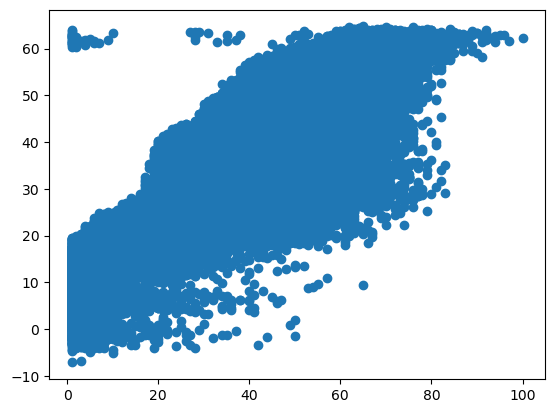

In [51]:
plt.scatter(y_test, predictions)

<Axes: xlabel='popularity', ylabel='Count'>

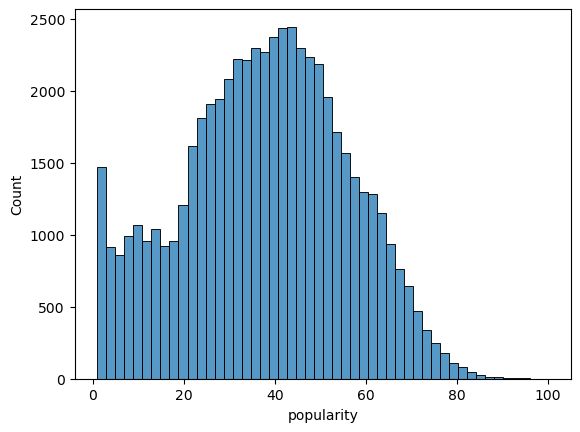

In [52]:
sns.histplot(y_test, bins=50)

<Axes: ylabel='Count'>

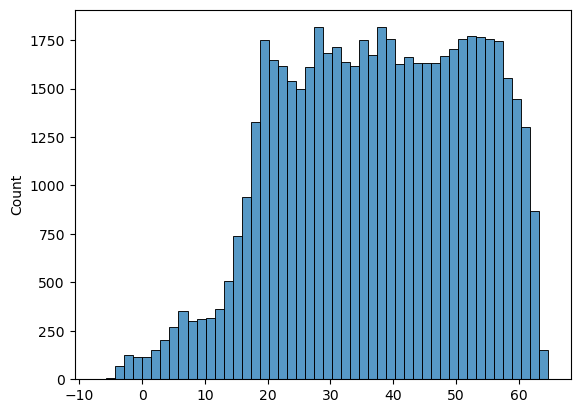

In [53]:
sns.histplot(predictions, bins=50)

Valor máximo da previsão

In [54]:
predictions.max()

64.72301783878675

Comparar os valores previstos com os reais

In [55]:
pd.merge(pd.DataFrame(y_test), pd.DataFrame(predictions), left_index=True, right_index=True)    

,popularity,0
53363,34,53.326400
4674,35,46.769085
6076,49,22.582290
55424,58,45.332110
51561,24,18.787379
...,...,...
45447,43,47.402873
21645,40,20.772682
7198,49,51.201504
15917,60,52.417134


Avaliação do Modelo

In [56]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 7.961902752894781
MSE: 105.37365078052018
RMSE: 10.265166865692938


#### Árvores de Decisão

Criação do modelo

In [57]:
dtree=DecisionTreeRegressor(random_state=2023)
dtree.fit(X_train,y_train)

DecisionTreeRegressor(random_state=2023)

Previsões do modelo

In [58]:
pred = dtree.predict(X_test)

In [59]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('R²:', np.sqrt(metrics.r2_score(y_test, pred)))

MAE: 10.263582109627654
MSE: 191.14446342625894
RMSE: 13.825500476520151
R²: 0.6467963787609335


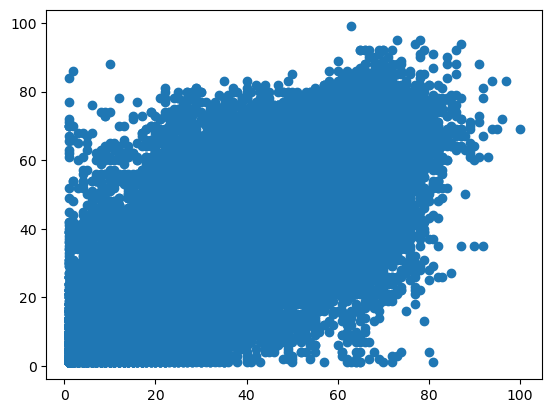

In [60]:
plt.scatter(y_test, pred)

Grid Search

In [61]:
# outros critérios: 'absolute_error', 'poisson'
param_grid = {'criterion':['squared_error', 'friedman_mse'],'max_depth':[4,5,6,7,8,9,10,11,12,15]}

grid_reg_bt = GridSearchCV(dtree, param_grid, refit=True, verbose=3)

In [62]:
grid_reg_bt.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END criterion=squared_error, max_depth=4;, score=0.699 total time=   0.2s
[CV 2/5] END criterion=squared_error, max_depth=4;, score=0.702 total time=   0.2s
[CV 3/5] END criterion=squared_error, max_depth=4;, score=0.704 total time=   0.2s
[CV 4/5] END criterion=squared_error, max_depth=4;, score=0.707 total time=   0.2s
[CV 5/5] END criterion=squared_error, max_depth=4;, score=0.715 total time=   0.2s
[CV 1/5] END criterion=squared_error, max_depth=5;, score=0.703 total time=   0.2s
[CV 2/5] END criterion=squared_error, max_depth=5;, score=0.706 total time=   0.2s
[CV 3/5] END criterion=squared_error, max_depth=5;, score=0.708 total time=   0.2s
[CV 4/5] END criterion=squared_error, max_depth=5;, score=0.710 total time=   0.2s
[CV 5/5] END criterion=squared_error, max_depth=5;, score=0.720 total time=   0.2s
[CV 1/5] END criterion=squared_error, max_depth=6;, score=0.704 total time=   0.3s
[CV 2/5] END criterion=sq

GridSearchCV(estimator=DecisionTreeRegressor(random_state=2023),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15]},
             verbose=3)

In [64]:
grid_reg_bt_predictions = grid_reg_bt.predict(X_test)

In [65]:
grid_reg_bt.best_params_

{'criterion': 'squared_error', 'max_depth': 7}

In [66]:
grid_reg_bt.best_estimator_

DecisionTreeRegressor(max_depth=7, random_state=2023)

In [67]:
print('MAE:', metrics.mean_absolute_error(y_test, grid_reg_bt_predictions))
print('MSE:', metrics.mean_squared_error(y_test, grid_reg_bt_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, grid_reg_bt_predictions)))
print('R²:', np.sqrt(metrics.r2_score(y_test, grid_reg_bt_predictions)))

MAE: 7.455565237779633
MSE: 95.14785492126157
RMSE: 9.754376193343251
R²: 0.842890360875511


#### Gradient Boosted Trees

In [ ]:
xgbreg=XGBRegressor()
xgbreg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
pred = xgbreg.predict(X_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 7.370115791367569
MSE: 93.06395171139172
RMSE: 9.646965932944498


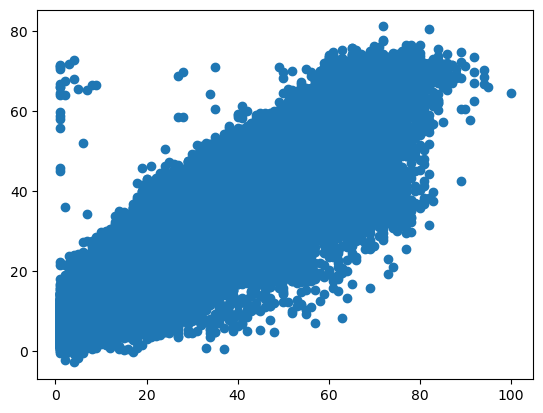

In [ ]:
plt.scatter(y_test, pred)

#### Tweedie Regressor
https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models

In [ ]:
model = TweedieRegressor(power=2, alpha=0.5, link='log')

In [ ]:
model.fit(X_train, y_train)

TweedieRegressor(alpha=0.5, link='log', power=2)

In [ ]:
pred = model.predict(X_test)
pred

array([41.57503697, 32.36681985, 45.7089313 , ..., 34.92759979,
       46.42035565, 44.20281985])

<Axes: ylabel='Count'>

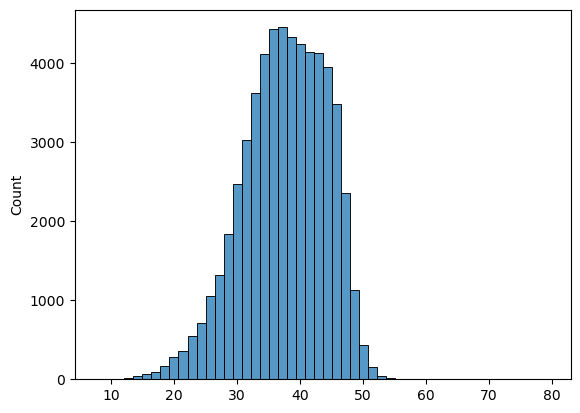

In [ ]:
sns.histplot(pred, bins=50)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 12.868259737090042
MSE: 254.16511281540232
RMSE: 15.942556658685655


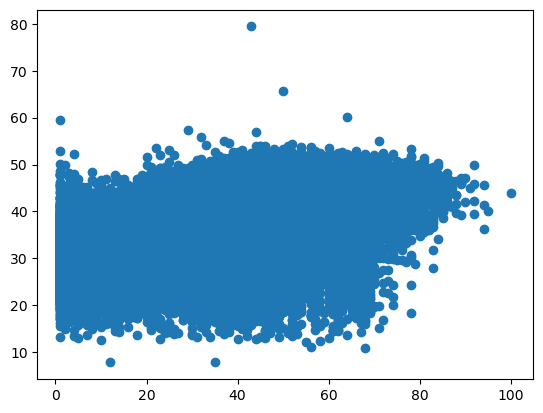

In [ ]:
plt.scatter(y_test, pred)

#### Random Forest

In [183]:
rf = RandomForestRegressor(n_estimators=100, random_state=2023)

In [184]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=2023)

In [186]:
pred = rf.predict(X_test)
pred

array([ 9.855, 50.61 , 22.19 , ...,  8.68 , 52.66 , 64.77 ])

In [187]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 7.474746636253991
MSE: 95.07593677812935
RMSE: 9.750689041197516


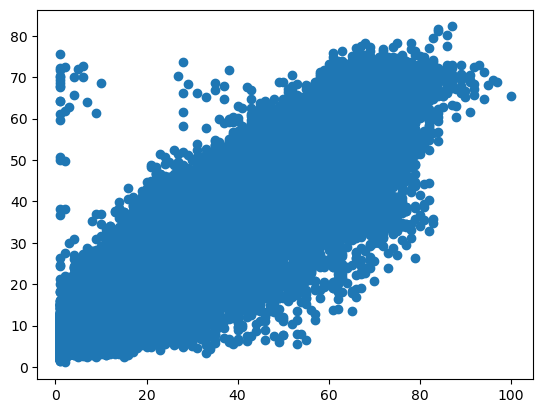

In [188]:
plt.scatter(y_test, pred)

Grid Search

In [ ]:
param_grid = {'criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

grid_reg_rf = GridSearchCV(rf, param_grid, refit=True, verbose=3)

In [ ]:
grid_reg_rf.fit(X_train, y_train)

In [ ]:
grid_reg_rf_pred = rf.predict(X_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, grid_reg_rf_pred))
print('MSE:', metrics.mean_squared_error(y_test, grid_reg_rf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, grid_reg_rf_pred)))

### Problema de Classificação

Uma outra forma de resolver este problema de previsão da popularidade de uma música consiste em transformar a feature 'popularity', target do nosso problema, numa feature discreta, dividindo a gama de valores contínuos (0 a 100) numa série de bins, ou seja intervalos de popularidade. Por exemplo, para 10 bins, o objetivo passaria a ser o de prever qual o nível de popularidade de uma música (Nível 0 - 0..10, Nível 1 - 10..20, etc)

Vamos então transformar a feature 'popularity' numa feature discreta, recorrendo à funcionalidade KBinsDiscretizer do módulo Sci-kit learn.
Este módulo permite realizar binning de duas estratégias diferentes:

- ‘uniform’: All bins in each feature have identical widths.

- ‘quantile’: All bins in each feature have the same number of points.

In [83]:
data_binned = data.copy()
estimator = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
data_binned['popularity_binned'] = estimator.fit_transform(data[['popularity']])
data_binned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142497 entries, 4 to 169908
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   acousticness       142497 non-null  float64
 1   danceability       142497 non-null  float64
 2   duration_ms        142497 non-null  int64  
 3   energy             142497 non-null  float64
 4   explicit           142497 non-null  int64  
 5   instrumentalness   142497 non-null  float64
 6   key                142497 non-null  int64  
 7   liveness           142497 non-null  float64
 8   loudness           142497 non-null  float64
 9   mode               142497 non-null  int64  
 10  popularity         142497 non-null  int64  
 11  speechiness        142497 non-null  float64
 12  tempo              142497 non-null  float64
 13  valence            142497 non-null  float64
 14  year               142497 non-null  int64  
 15  popularity_binned  142497 non-null  float64
dtypes: floa

array([[<Axes: title={'center': 'popularity_binned'}>]], dtype=object)

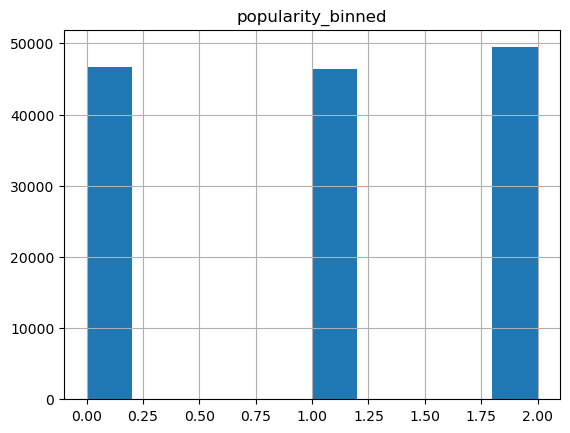

In [85]:
data_binned.hist(column='popularity_binned')

In [84]:
data_binned.groupby(by=['popularity_binned']).mean()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
popularity_binned,,,,,,,,,,,,,,,
0.0,0.643425,0.504251,223942.336319,0.401616,0.005292,0.193735,5.121341,0.217382,-13.238485,0.734862,16.968824,0.074935,115.449002,0.536173,1962.368267
1.0,0.350746,0.545385,244278.726436,0.569076,0.065346,0.117730,5.241204,0.204586,-10.475989,0.716993,37.710676,0.072714,119.829191,0.555300,1986.150849
2.0,0.278140,0.587287,235381.167405,0.620183,0.183524,0.072806,5.246142,0.187989,-8.266365,0.679833,57.004632,0.085947,120.493430,0.517920,2002.486864


### Modelo de Árvores de Decisão

Vamos agora criar um modelo de árvores de decisão para prever o intervalo de popularidade de uma música.

In [96]:
"""
Hyperparameters:
criterion - The function to measure the quality of a split.
    "entropy" - Entropy = 0 means it is pure split (all instances are of only 1 class). Entropy = 1 means it is impure split.
    "gini" - 
max_depth - The maximum number of levels in the tree.
min_samples_leaf - The minimum number of samples allowed in a leaf.
min_samples_split - The minimum number of samples required to split an internal node.
"""
classifier = DecisionTreeClassifier(random_state=2023, criterion='entropy', splitter='best') 

Before training the model, we must assure that all features are non categorical.

In [97]:
continous_features = data_binned.copy()
#continous_features['artist_name'] = lb_make.fit_transform(continous_features['artist_name'])
#continous_features['genre'] = lb_make.fit_transform(continous_features['genre'])
#continous_features

In [98]:
X_dt = continous_features.drop(['popularity', 'popularity_binned'], axis=1)
y_dt = continous_features['popularity_binned'].to_frame()

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.25, random_state=101)

In [100]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=2023)

In [101]:
d_tree_predictions = classifier.predict(X_test)
d_tree_predictions

array([0., 2., 0., ..., 1., 1., 2.])

In [102]:
df = pd.DataFrame(d_tree_predictions, columns = ['prediction_binned'])
pred_actual = df.merge(right=y_test, left_index=True, right_index=True)
pred_actual.head()

,prediction_binned,popularity_binned
4,0.0,0.0
59,1.0,0.0
75,2.0,0.0
81,2.0,0.0
84,0.0,0.0


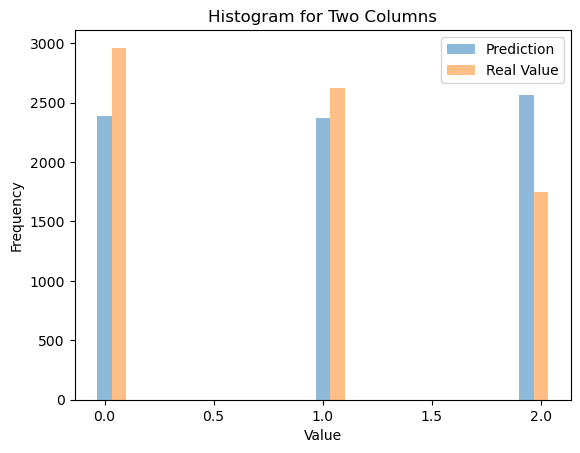

In [103]:
# Create histograms for each column
plt.hist(pred_actual['prediction_binned'], align='left', bins=30, alpha=0.5, label='Prediction')
plt.hist(pred_actual['popularity_binned'], align='right', bins=30, alpha=0.5, label='Real Value')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram for Two Columns')
plt.legend()  # Show legend with labels

# Display the plot
plt.show()

In [104]:
confusion_matrix(y_test, d_tree_predictions)

array([[8174, 2552,  882],
       [2597, 5615, 3356],
       [ 916, 3391, 8142]])

In [105]:
accuracy_score(y_test, d_tree_predictions)

0.6156070175438596

In [106]:
f1_score(y_test, d_tree_predictions, average='weighted')

0.6155321914518275

In [107]:
precision_score(y_test, d_tree_predictions, average='weighted')

0.6154662240433298

In [108]:
recall_score(y_test, d_tree_predictions, average='weighted')

0.6156070175438596

##### Árvores de Decisão com cross-validation

In [63]:
cross_valid_model = LinearRegression()

In [64]:
scores = cross_val_score(classifier, X_dt, y_dt, cv=5, scoring='accuracy')

In [66]:
scores.mean()

0.5778646305225853

In [67]:
scores.std()

0.0732470242083767

Grid Search

In [109]:
param_grid = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

grid_clf_dtrees = GridSearchCV(classifier, param_grid, refit=True, verbose=3)

In [110]:
grid_clf_dtrees.fit(X_dt, y_dt)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END .......criterion=gini, max_depth=4;, score=0.798 total time=   0.4s
[CV 2/5] END .......criterion=gini, max_depth=4;, score=0.567 total time=   0.4s
[CV 3/5] END .......criterion=gini, max_depth=4;, score=0.417 total time=   0.4s
[CV 4/5] END .......criterion=gini, max_depth=4;, score=0.689 total time=   0.4s
[CV 5/5] END .......criterion=gini, max_depth=4;, score=0.850 total time=   0.4s
[CV 1/5] END .......criterion=gini, max_depth=5;, score=0.797 total time=   0.5s
[CV 2/5] END .......criterion=gini, max_depth=5;, score=0.570 total time=   0.5s
[CV 3/5] END .......criterion=gini, max_depth=5;, score=0.417 total time=   0.5s
[CV 4/5] END .......criterion=gini, max_depth=5;, score=0.629 total time=   0.5s
[CV 5/5] END .......criterion=gini, max_depth=5;, score=0.830 total time=   0.5s
[CV 1/5] END .......criterion=gini, max_depth=6;, score=0.784 total time=   0.6s
[CV 2/5] END .......criterion=gini, max_depth=6

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=2023),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]},
             verbose=3)

In [112]:
grid_clf_dtrees.best_params_

{'criterion': 'entropy', 'max_depth': 4}

In [113]:
grid_clf_dtrees.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=2023)

In [114]:
grid_dtrees_predictions = grid_clf_dtrees.predict(X_test)
print(classification_report(y_test, grid_dtrees_predictions))

              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76     11608
         1.0       0.54      0.72      0.61     11568
         2.0       0.81      0.65      0.72     12449

    accuracy                           0.69     35625
   macro avg       0.72      0.69      0.70     35625
weighted avg       0.72      0.69      0.70     35625



In [115]:
accuracy_score(y_test, grid_dtrees_predictions)

0.6935298245614036

In [116]:
f1_score(y_test, grid_dtrees_predictions, average='weighted')

0.7001395215510425

In [117]:
precision_score(y_test, grid_dtrees_predictions, average='weighted')

0.7233567434975023

In [118]:
recall_score(y_test, grid_dtrees_predictions, average='weighted')

0.6935298245614036

### Logistic Regression

In [48]:
from sklearn import linear_model

In [49]:
log_reg = linear_model.LogisticRegression(solver = 'lbfgs', max_iter = 1000)

In [170]:
log_reg.fit(X_train, y_train)

/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [172]:
lr_predictions = log_reg.predict(X_test)
lr_predictions

array([1., 2., 2., ..., 2., 2., 2.])

In [173]:
df = pd.DataFrame(lr_predictions, columns = ['prediction_binned'])
pred_actual = df.merge(right=y_test, left_index=True, right_index=True)
pred_actual.head()

,prediction_binned,popularity_binned
4,1.0,0.0
59,2.0,0.0
75,2.0,0.0
81,2.0,0.0
84,2.0,0.0


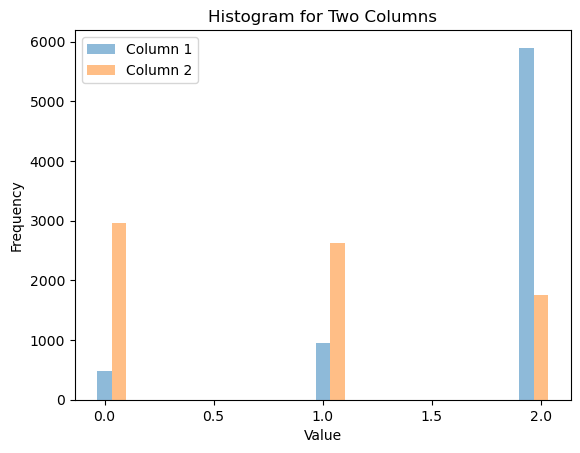

In [174]:
# Create histograms for each column
plt.hist(pred_actual['prediction_binned'], align='left', bins=30, alpha=0.5, label='Column 1')
plt.hist(pred_actual['popularity_binned'], align='right', bins=30, alpha=0.5, label='Column 2')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram for Two Columns')
plt.legend()  # Show legend with labels

# Display the plot
plt.show()

In [177]:
confusion_matrix(y_test, lr_predictions)

array([[ 1309,  1586,  8713],
       [  651,  1715,  9202],
       [  441,  1129, 10879]])

In [178]:
accuracy_score(y_test, lr_predictions)

0.39025964912280703

In [179]:
r2_score(y_test, lr_predictions)

-1.046166336906495

In [180]:
f1_score(y_test, lr_predictions, average='weighted')

0.31486451930480275

In [181]:
precision_score(y_test, lr_predictions, average='weighted')

0.4353801998881727

In [182]:
recall_score(y_test, lr_predictions, average='weighted')

0.39025964912280703

Grid Search

In [50]:
param_grid = {"C" : np.logspace(-3,3,7), "penalty" : ["l1","l2"]}

grid_clf_lr = GridSearchCV(log_reg, param_grid, refit=True, verbose=3)

In [51]:
grid_clf_lr.fit(X_dt, y_dt)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.374 total time=   1.1s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.374 total time=   1.1s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.388 total time=   1.5s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.369 total time=   1.1s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.369 total time=   1.2s
[CV 1/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ................C=0.01, penalty=l2;, score=0.374 total time=   0.9s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ................C=0.01, penalty=l2;, score=0.374 total time=   1.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ................C=0.01, penalty=l2;, score=0.388 total time=   2.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ................C=0.01, penalty=l2;, score=0.369 total time=   1.2s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ................C=0.01, penalty=l2;, score=0.369 total time=   1.0s
[CV 1/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .................C=0.1, penalty=l2;, score=0.374 total time=   0.9s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .................C=0.1, penalty=l2;, score=0.374 total time=   1.1s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .................C=0.1, penalty=l2;, score=0.388 total time=   1.7s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .................C=0.1, penalty=l2;, score=0.369 total time=   1.1s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .................C=0.1, penalty=l2;, score=0.369 total time=   1.1s
[CV 1/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=1.0, penalty=l1;, score=nan total time=   0.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .................C=1.0, penalty=l2;, score=0.374 total time=   1.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .................C=1.0, penalty=l2;, score=0.374 total time=   1.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .................C=1.0, penalty=l2;, score=0.388 total time=   2.2s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .................C=1.0, penalty=l2;, score=0.369 total time=   1.5s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .................C=1.0, penalty=l2;, score=0.369 total time=   1.2s
[CV 1/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ..................C=10.0, penalty=l1;, score=nan total time=   0.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ................C=10.0, penalty=l2;, score=0.374 total time=   1.2s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ................C=10.0, penalty=l2;, score=0.374 total time=   1.3s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ................C=10.0, penalty=l2;, score=0.388 total time=   2.3s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ................C=10.0, penalty=l2;, score=0.369 total time=   1.5s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ................C=10.0, penalty=l2;, score=0.369 total time=   1.3s
[CV 1/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .................C=100.0, penalty=l1;, score=nan total time=   0.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ...............C=100.0, penalty=l2;, score=0.374 total time=   1.1s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...............C=100.0, penalty=l2;, score=0.374 total time=   1.2s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...............C=100.0, penalty=l2;, score=0.388 total time=   2.3s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...............C=100.0, penalty=l2;, score=0.369 total time=   1.7s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...............C=100.0, penalty=l2;, score=0.369 total time=   1.3s
[CV 1/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ................C=1000.0, penalty=l1;, score=nan total time=   0.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ..............C=1000.0, penalty=l2;, score=0.374 total time=   1.0s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..............C=1000.0, penalty=l2;, score=0.374 total time=   1.5s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ..............C=1000.0, penalty=l2;, score=0.388 total time=   2.2s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..............C=1000.0, penalty=l2;, score=0.369 total time=   1.3s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..............C=1000.0, penalty=l2;, score=0.369 total time=   1.5s


/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sk

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [52]:
grid_clf_lr.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [54]:
grid_clf_lr.best_estimator_

LogisticRegression(C=0.001, max_iter=1000)

In [55]:
grid_lr_predictions = grid_clf_lr.predict(X_test)
print(classification_report(y_test, grid_lr_predictions))

              precision    recall  f1-score   support

         0.0       0.59      0.03      0.05     11608
         1.0       0.39      0.14      0.21     11568
         2.0       0.37      0.91      0.52     12449

    accuracy                           0.37     35625
   macro avg       0.45      0.36      0.26     35625
weighted avg       0.44      0.37      0.27     35625



### Support Vector Machines

In [183]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [185]:
svc_model = SVC(random_state=2023)

In [186]:
#svc_model.fit(X_train, y_train)

/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1]:
#svc_predictions = svc_model.predict(X_test)

In [ ]:
df = pd.DataFrame(lr_predictions, columns = ['prediction_binned'])
pred_actual = df.merge(right=y_test, left_index=True, right_index=True)
pred_actual.head()

In [ ]:
# Create histograms for each column
plt.hist(pred_actual['prediction_binned'], align='left', bins=30, alpha=0.5, label='Column 1')
plt.hist(pred_actual['popularity_binned'], align='right', bins=30, alpha=0.5, label='Column 2')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram for Two Columns')
plt.legend()  # Show legend with labels

# Display the plot
plt.show()

In [ ]:
confusion_matrix(y_test, lr_predictions)

In [ ]:
accuracy_score(y_test, lr_predictions)

In [ ]:
r2_score(y_test, lr_predictions)

In [ ]:
f1_score(y_test, lr_predictions, average='weighted')

In [ ]:
precision_score(y_test, lr_predictions, average='weighted')

In [ ]:
recall_score(y_test, lr_predictions, average='weighted')

### Clustering

In [45]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

In [64]:
selected_features_clustering = ['popularity']

In [81]:
final_data = data.copy()
final_data = final_data[selected_features_clustering]
final_data

,popularity
4,1
11,1
40,1
42,2
47,2
...,...
169904,75
169905,64
169906,70
169907,70


#### KMeans

In [87]:
"""
n_clusters: The number of clusters to form as well as the number of centroids to generate.
n_init: Number of times the k-means algorithm is run with different centroid seeds.
"""
kmeans = KMeans(n_clusters=2, n_init=10, random_state=2023)
kmeans.fit(final_data)

KMeans(n_clusters=2, n_init=10, random_state=2023)

In [88]:
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [89]:
result = pd.merge(pd.DataFrame(final_data), pd.DataFrame(kmeans.labels_, columns=["label"]), left_index=True, right_index=True)    
#result = pd.merge(pd.DataFrame(X_test), pd.DataFrame(result), left_index=True, right_index=True)    
result

,popularity,label
4,1,0
11,1,0
40,1,0
42,2,0
47,2,0
...,...,...
142505,49,1
142506,44,1
142507,48,1
142508,55,1


Verificar se existe correlação entre a label e a popularidade

<Axes: >

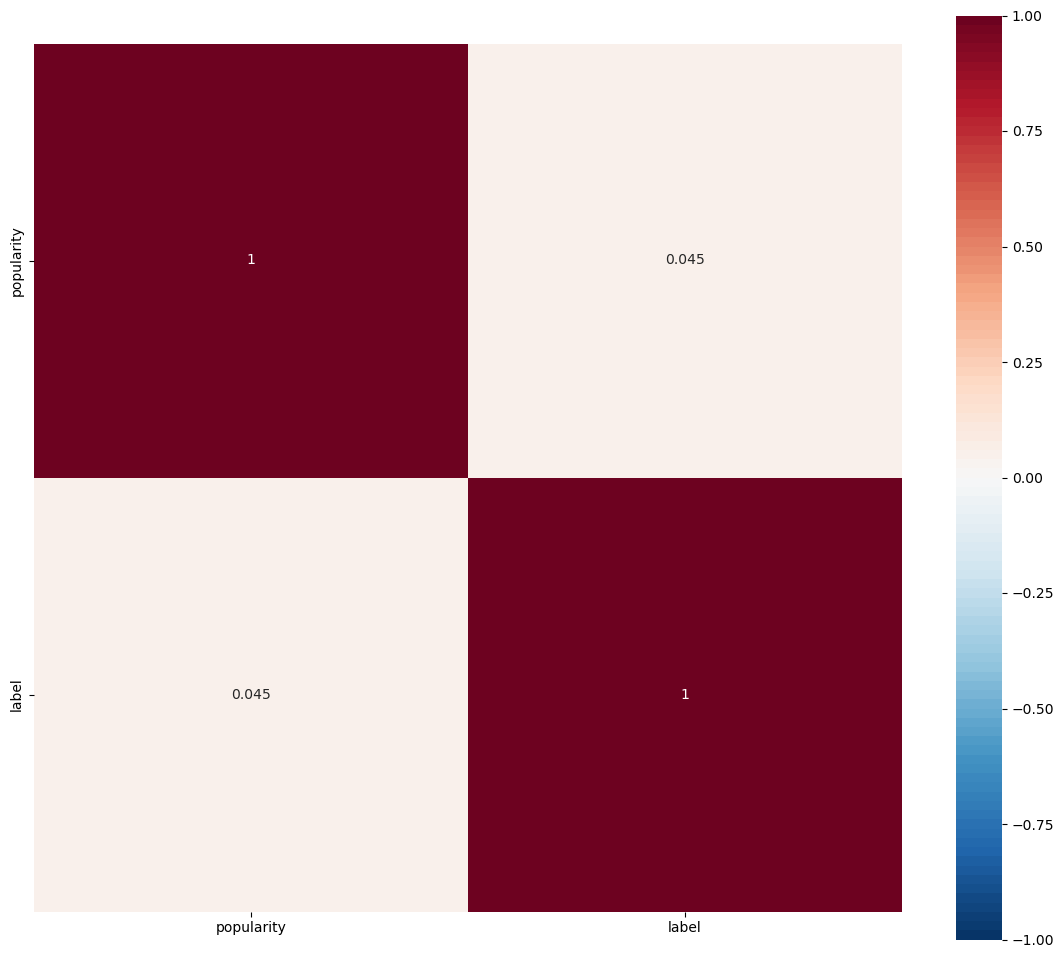

In [90]:
corr_matrix = result.corr(method='pearson', numeric_only=True)
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True, cmap=sns.color_palette("RdBu_r", 100))

In [92]:
result.groupby(by=['label']).mean(numeric_only=True)

,popularity
label,
0,36.515236
1,38.167224


#### KMedoids

In [93]:
from sklearn_extra.cluster import KMedoids

In [104]:
kMedoids = KMedoids(n_clusters=3, random_state=2023)
kMedoids.fit(final_data.sample(frac=0.1)) # Se usar os dados todos dá erro de memória

/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
/home/miguel/miniconda3/envs/firstCondaEnv/lib/python3.10/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(


KMedoids(n_clusters=3, random_state=2023)

In [105]:
kMedoids.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [106]:
result_kMedoids = pd.merge(pd.DataFrame(final_data), pd.DataFrame(kMedoids.labels_, columns=["label"]), left_index=True, right_index=True)    
#result = pd.merge(pd.DataFrame(X_test), pd.DataFrame(result), left_index=True, right_index=True)    
result_kMedoids

,popularity,label
4,1,0
11,1,0
40,1,0
42,2,0
47,2,0
...,...,...
14246,40,0
14247,48,0
14248,47,0
14249,46,0


<Axes: >

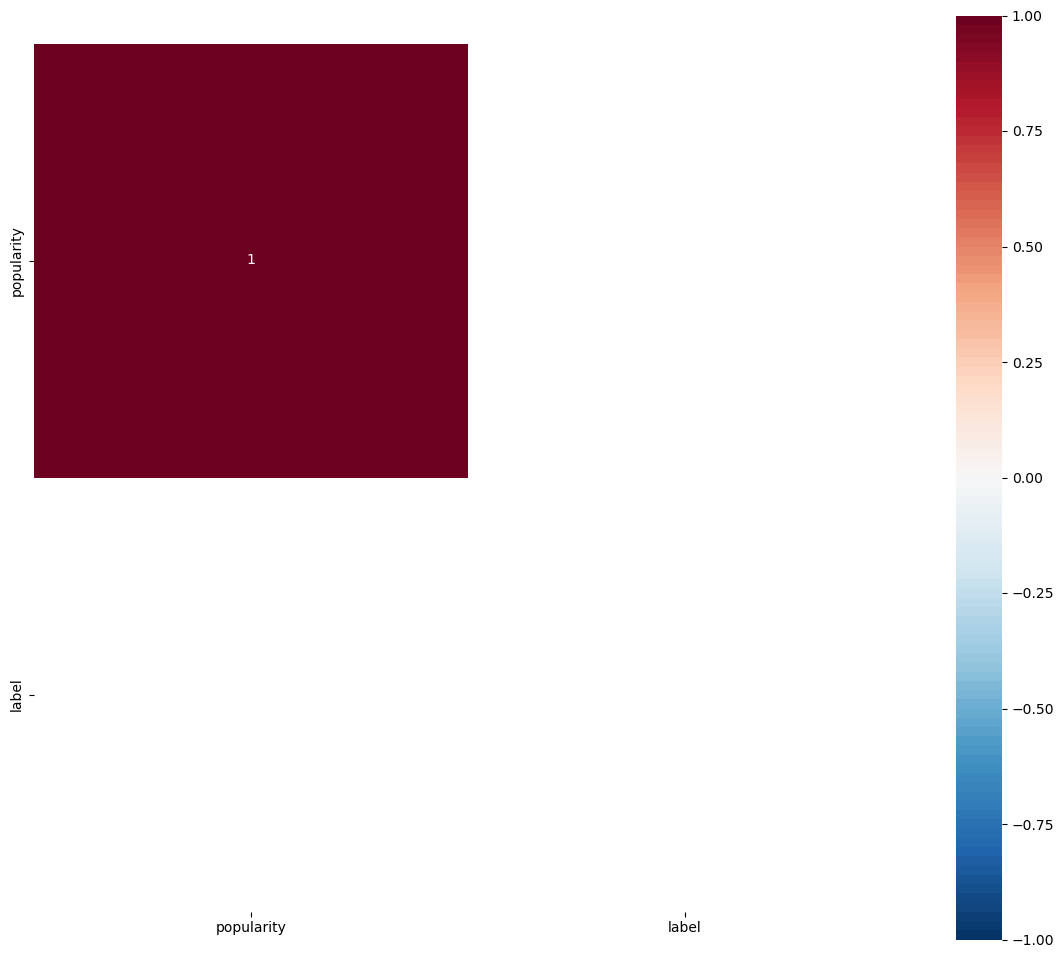

In [107]:
corr_matrix = result_kMedoids.corr(method='pearson', numeric_only=True)
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True, cmap=sns.color_palette("RdBu_r", 100))

In [103]:
result_kMedoids.groupby(by=['label']).mean(numeric_only=True)

,popularity
label,
0,32.494569
